In [1]:
import glob
import re
import os
import sys
import kipoi
import numpy as np
import datetime
import warnings
import pandas as pd
import matplotlib.pyplot as plt
start = datetime.datetime.now()

old_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")
model = kipoi.get_model('DeepSEA/predict')
sys.stdout = old_stdout
batch_size=100
#sys.argv=[" ","5_158526788",5000,"gene_name",1,100,500000]
sys.argv=[" ","2_127864931",5000,"BIN1",1,100,500000]
sys.argv[2]=int(sys.argv[2])
sys.argv[4]=int(sys.argv[4])
sys.argv[5]=int(sys.argv[5])
sys.argv[6]=int(sys.argv[6])
#print(sys.argv[1])
with open("temp/"+sys.argv[1]+"/expression/"+sys.argv[1]+".tsv") as f:
    content = f.readlines()

content = [x.strip() for x in content]
content[0] = content[0].split()
content[1] = content[1].split()
answ=np.empty([sys.argv[2],445,919])
expr=np.empty([445])
i=0


In [2]:
for g in sorted(glob.glob("temp/"+sys.argv[1]+"/fa_output/out"+sys.argv[1]+"_*.fa.gz")):
    dl_kwargs = {'intervals_file': 'temp/'+sys.argv[1]+'/intervals/'+os.path.splitext(os.path.basename(g))[0], 'fasta_file': g, "num_chr_fasta": "False"}
    warnings.filterwarnings('ignore',category=FutureWarning)
    dl = model.default_dataloader(**dl_kwargs)
    #it = dl.batch_iter(batch_size=sys.argv[2])
    it = dl.batch_iter(batch_size=batch_size)
    for b in range(0,sys.argv[2],batch_size):
        batch = next(it)
        warnings.filterwarnings('default',category=FutureWarning)
        if (sys.argv[2]<=b+batch_size):
            answ[b:sys.argv[2],i,:]=model.predict_on_batch(batch['inputs'])
        else:
            answ[b:b+batch_size,i,:]=model.predict_on_batch(batch['inputs'])
    expr[i]=content[1][content[0].index(re.split('_|\.',g)[-3])]
    i+=1

In [3]:
answ[1,:,:].shape

(445, 919)

/home/antoine/miniconda3/envs/kipoi-gpu-DeepSEA__predict/lib/python3.7/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 6.250e-04
  % (max_iter, d_gap), ConvergenceWarning)


Text(0.5, 1.0, 'GraphicalLasso covariance')

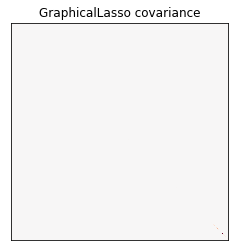

In [7]:
from sklearn.covariance import GraphicalLasso
model = GraphicalLasso(max_iter=1000)
#X = (n_samples = 445*5000, n_features=919) answ=np.empty([sys.argv[2],445,919])
X = answ[1,:,:]
#X = answ.reshape([sys.argv[2]*445,919)
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

vmax = cov_.max()
plt.imshow(cov_, interpolation='nearest', vmin=-vmax, vmax=vmax,
           cmap=plt.cm.RdBu_r)
plt.xticks(())
plt.yticks(())
plt.title('%s covariance' % "GraphicalLasso")

In [ ]:
precs = [('Empirical', linalg.inv(emp_cov)), ('Ledoit-Wolf', lw_prec_),
         ('GraphicalLasso', prec_), ('True', prec)]
vmax = .9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(np.ma.masked_equal(this_prec, 0),
               interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s precision' % name)
    if hasattr(ax, 'set_facecolor'):
        ax.set_facecolor('.7')
    else:
        ax.set_axis_bgcolor('.7')
